## Contrastive pre-training

### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

**Student**: Naïl Khelifa

Here, we will try the SimCLR method.

[1] T. Chen et al. “A Simple Framework for Contrastive Learning of Visual Representations”. In: ICML. 2020.


In [1]:
import os
import shutil
import yaml
import logging
import sys
import zipfile
from copy import deepcopy


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

## Torchvision
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.datasets import STL10, PCAM
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn

## Plot Options
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
plt.set_cmap("cividis")
%matplotlib inline
sns.set_theme()

## SKlearn
from sklearn.linear_model import LogisticRegression


# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)


try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
  import gdown
except:
  IN_COLAB = False

Hfactory=True # put equal to True, if you are using HFactory
if Hfactory:
    !pip install gdown==4.6.0 # with the following versions, there is an error  
    !pip uninstall -y h5py
    !pip install h5py
    import h5py
    import gdown

Number of workers: 104
Found existing installation: h5py 3.12.1
Uninstalling h5py-3.12.1:
  Successfully uninstalled h5py-3.12.1
  Using cached h5py-3.12.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
Using cached h5py-3.12.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.4 MB)


<Figure size 640x480 with 0 Axes>

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = torch.device("cuda:0") # we use one GPU, the first one
    print ("CUDA device found.")
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.6.0+cu124
CUDA device found.


### Data Augmentation for Contrastive Learning

One of the key points of SimCLR is the choice of the augmentation strategy. It composes many different geometric and iconographic transformations.
We can implement them very efficiently and easily using the Dataset object of Pytorch.

Since in SimCLR authors use 2 views, we do the same here. Please note that we could use more positives

The transformations used are: (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_data_augmentations.jpg" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

When using ImageNet-derived datasets, the two most important transformations are: crop-and-resize, and color distortion.
Interestingly, they need to be used together since, when combining randomly cropping and resizing, we might have two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in the representation space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view.
However, the network can use the color information (color histograms) to create a useless link between the two patches, without learning generalizable high-level representations. For instance, it could focus on the color of the fur of the dog and on the color of the background to understand that the two patches belong to the same image. That's why, we need to compose crop-and-resize and color distortion.

**Question**: Create a Pytorch class of transformations (transforms.Compose) where you apply the following augmentations:
- Resize an Crop
- Horizontal Flip
- Color jittering
- Gray scale changes
- Gaussian Blur

Hint: all functions have already been implemented and can be found here: https://pytorch.org/vision/0.9/transforms.html

Alternatively, you can also use [albumentations](https://albumentations.ai/) by simply adding:

`import albumentations as A`

`from albumentations.pytorch.transforms import ToTensorV2`

In [4]:
import torchvision.transforms as transforms

class ContrastiveTransformations:
    def __init__(self, img_size, s=1):
        # Strength factor `s` can adjust the magnitude of color jittering
        self.data_transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        # Return two views (augmentations) of the same image
        return self.data_transform(x), self.data_transform(x)

In [5]:
# simple transformation to use networks pre-trained on ImageNet
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

**Question**: What's the difference between `ContrastiveTransformations` and `img_transforms` ? Look inside the functions and their outputs...

`ContrastiveTransformations` and `img_transforms` differ in four aspects:

1. **Augmentation vs. Normalization**:
- `ContrastiveTransformations`: Applies several data augmentation techniques like resizing, random cropping, horizontal flipping, color jittering, grayscale conversion, and Gaussian blur. This pipeline alters the image significantly to produce multiple views of the same image.
- `img_transforms`: Primarily responsible for data standardization, without augmenting the image content itself.
Only converts the image to a tensor and applies normalization based on ImageNet statistics.
2. **Outputs**:
- `ContrastiveTransformations`: Returns **two distinct** augmented views of the same input image. This is useful for contrastive learning methods like SimCLR, which need multiple views of the same image for training.
- `img_transforms`: Returns **a single normalized tensor** without generating multiple views.
3. **Use Case**s:
- `ContrastiveTransformations`: Best suited for self-supervised contrastive learning tasks (such as SimCLR)
- `img_transforms`: deal for *standard supervised learning pipelines*, where clean, normalized images are fed directly to models.

In [6]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [7]:
if IN_COLAB:
    #data_directory="./" # decomment it if you do NOT use Google Drive
    data_directory="/content/drive/MyDrive/TP/"  # decomment it if you USE Google Drive and copy/paste the path to your Google Drive
elif Hfactory:
    data_directory="./"    
else:
    data_directory="/Users/pgori/Nextcloud/Lavoro/Corsi/MachineLearning/DataSets-TP/" # copy/paste the path of the folder with STL dataset in your computer

We create unlabeled, training and test Datasets.
Please be careful since we use two different transformations, one for the unlabelled part and one for train/test set.

In [8]:
import os

# Define the data path relative to the user's home directory
data_directory = os.path.expanduser("~/my_stl10_data/")
os.makedirs(data_directory, exist_ok=True)
print(f"Data directory set to: {data_directory}")

Data directory set to: /home/onyxia/my_stl10_data/


In [9]:
unlabeled_dataset_2viewsCon = STL10(root=data_directory+"data", split="unlabeled", download=True, transform=ContrastiveTransformations(96))
train_dataset = STL10(root=data_directory+"data", split="train", download=True, transform=img_transforms)
# just to show the effect of the augmentations and the classes
train_dataset_2viewsCon = STL10(root=data_directory+"data", split="train", download=True, transform=ContrastiveTransformations(96))
test_dataset = STL10(root=data_directory+"data", split="test", download=True, transform=img_transforms)

In [10]:
# To check the classes in STL10
classes=unlabeled_dataset_2viewsCon.classes
print(classes)
print('Number images in Unlabeled dataset:' ,len(unlabeled_dataset_2viewsCon))
print(unlabeled_dataset_2viewsCon[0][0][0].shape) # this is one image (the first of the 2-views tuple)

# Train dataset
labels=train_dataset.labels # retrieve label of each sample
print('Number images in Train dataset:' , len(train_dataset)) # retrieve length of dataset
print(train_dataset[3][0].shape) # this is one image

#Test dataset
print('Number images in Test dataset:' ,len(test_dataset))
print(test_dataset[0][0].shape) # this is one image

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number images in Unlabeled dataset: 100000
torch.Size([3, 96, 96])
Number images in Train dataset: 5000
torch.Size([3, 96, 96])
Number images in Test dataset: 8000
torch.Size([3, 96, 96])


The Unlabeled dataset contains 100k images. Here, to limit memory requirement, we will use 10% of the data.

In [11]:
sizeUnlabelled=5000

unlabeled_dataset_2viewsCon_red,rest = random_split(unlabeled_dataset_2viewsCon, [sizeUnlabelled, len(unlabeled_dataset_2viewsCon)-sizeUnlabelled])
len(unlabeled_dataset_2viewsCon_red)
del unlabeled_dataset_2viewsCon # free memory

We can also create a function to visualize the views of each sample, based on the chosen augmentation strategy.

In [12]:
def imshowSTL102views(datasetOrig,datasetTransform,rows=5,figsize=(8, 15)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, 3*(rows-1)+2,3):
      imgOrig = datasetOrig[i][0]
      img1=datasetTransform[i][0][0]
      img2=datasetTransform[i][0][1]

      #REMOVE NORMALIZATION
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
      # Clip values to range [0,1] -> possible rounding errors during normalization
      imgOrig = np.clip(unnormalize(imgOrig).numpy(),0,1)
      img1 = np.clip(unnormalize(img1).numpy(),0,1)
      img2 = np.clip(unnormalize(img2).numpy(),0,1)

      label = datasetOrig[i][1]
      fig.add_subplot(rows, 3, i)
      plt.title(datasetOrig.classes[label]+ ' , original')
      plt.imshow(np.transpose(imgOrig, (1, 2, 0)))
      plt.axis("off")
      fig.add_subplot(rows, 3, i+1)
      plt.title(datasetOrig.classes[label] + ' , 1st view')
      plt.imshow(np.transpose(img1, (1, 2, 0)))
      plt.axis("off")
      fig.add_subplot(rows, 3, i+2)
      plt.title(datasetOrig.classes[label] + ' , 2nd view')
      plt.imshow(np.transpose(img2, (1, 2, 0)))
      plt.axis("off")
    plt.show()

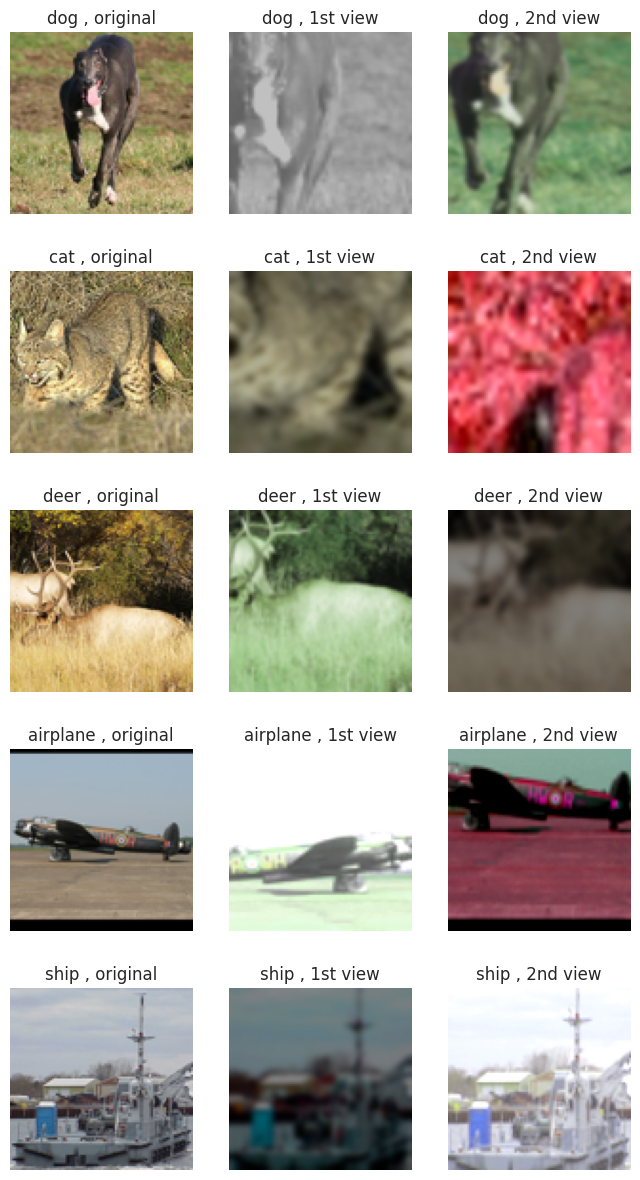

In [13]:
imshowSTL102views(train_dataset,train_dataset_2viewsCon)

In [14]:
del train_dataset_2viewsCon # To free memory

Here, it's the most important part of the code.

I remind you that the Siamese architecture of SimCLR is: (figure credit - [Ting Chen et al. ](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_network_setup.svg" width="350px"></center>

The employed loss is the InfoNCE loss:
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$
where $\tau$ is the temperature and the similarity measure is the cosine similarity:
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$
The maximum cosine similarity possible is $1$, while the minimum is $-1$.

After training, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor.


**Question**: Comment the code where you see **XXXXXXXXXXXXXXXXXX** explaining in details what the code is doing.

PS: if you are using a MacBook, you might have issues with multiprocessing. In that case, please use Google Colab.

In [15]:
class SimCLR():

    def __init__(self, model, optimizer, scheduler, device, batch_size, temperature, epochs):
        self.device=device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.temperature=temperature
        self.batch_size=batch_size
        self.epochs=epochs


    def info_nce_loss(self, features):

        # **Generating positive and negative pairs for contrastive learning**
        # `labels` is a matrix of size (2 * batch_size, 2 * batch_size).
        # It encodes which feature vectors are "positive pairs" (coming from the same original image).
        # For example, label[i][j] = 1 means that `features[i]` and `features[j]` belong to the same image view.
        labels = torch.cat([torch.arange(self.batch_size) for i in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        # **Normalizing the feature vectors to unit length**
        # Ensures that cosine similarity computation becomes equivalent to dot product.
        features = F.normalize(features, dim=1)  # XXXXXXXXXXX

        # **Computing the similarity matrix**
        # This matrix contains pairwise cosine similarities between all feature vectors.
        similarity_matrix = torch.matmul(features, features.T)  # XXXXXXXX

        # **Removing self-similarities from the similarity matrix and label matrix**
        # The diagonal entries represent similarities between identical vectors (self-similarity).
        # These are excluded from further computations.
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)  # XXXXXXXXX

        # **Extracting positive pairs from the similarity matrix**
        # `positives` contains similarity scores for pairs from the same augmented view.
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)  # XXXXXXXX

        # **Extracting negative pairs from the similarity matrix**
        # `negatives` contains similarity scores for pairs from different augmented views.
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)  # XXXXXXXXX

        # **Creating logits for InfoNCE loss calculation**
        # Concatenates positive and negative pairs to form logits.
        # Labels are set to zero to indicate that the first entry in each row is a positive pair.
        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)  # XXXXXXXXXXXX

        # **Scaling logits by the temperature parameter**
        # Dividing by temperature sharpens or smoothens the distribution, controlling learning stability.
        logits = logits / self.temperature  # XXXXXXXXXXXX
        return logits, labels

    def train(self, train_loader, use_amp = False):
        
        # Initialize the GradScaler if using mixed-precision training
        scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None

        n_iter = 0
        print("Start SimCLR training for {} epochs.".format(self.epochs))

        for epoch_counter in range(self.epochs):
            for images, _ in tqdm(train_loader):
                
                # **Concatenating images from two augmented views into a single batch**
                # This prepares the input for the Siamese network in SimCLR.
                images = torch.cat(images, dim=0)  # XXXXXXXX
                images = images.to(self.device)

                if torch.cuda.is_available() and use_amp:
                    # Mixed precision training using `autocast` to reduce memory usage and speed up computation
                    with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
                        features = self.model(images)
                        logits, labels = self.info_nce_loss(features)
                        loss = self.criterion(logits, labels)
                else:   
                    # Standard loss calculation without mixed precision
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)  # XXXXXXXX

                self.optimizer.zero_grad()

                # **Gradient scaling and backpropagation**
                if scaler is not None:
                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    self.optimizer.step()

                n_iter += 1

            # Warm-up for the first 5 epochs before adjusting the learning rate
            if epoch_counter >= 5:
                self.scheduler.step()

            print('Epoch: {}, Average loss: {:.4f}, lr: {:.4f}'.format(epoch_counter, loss / len(train_loader.dataset), self.scheduler.get_last_lr()[0] ))

        print("Training has finished.")


As before, we use a DataLoader.

DataLoader wraps an iterable around the Dataset to enable easy access to the samples. The Dataset retrieves our dataset features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.


In [16]:
bs = 32 # choose an appropriate batch size depending on the computational resources

train_unlabelled_loader = DataLoader(dataset=unlabeled_dataset_2viewsCon_red, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)

Here we define the hyper-parameters, optimization, scheduler and launch the training.

**Question**: complete the code where you see XXXXX.

As model for $f()$, use a ResnNet18 not-pretrained. Remember that the model ResNet18 has already a Linear Layer at the end (fc) which can be written as $Wf(x)$. You can also change the `out_features` of the fc by adding the option `num_classes=XXXX` while loading the model.

 As projection head, use the one from the article

 $$ g(f(x))=W^a \sigma (W^b f(x))$$

 where $\sigma$ is a Relu non-linearity.

In [17]:
max_epochs=2
lr=0.003
wd=1e-4
temperature=0.07
#f_dim=512 # to use if you want to change the output dimension of f
g_dim=128 # the output dimension of the projection head

# Ensure that you are using GPU and all CPU workers
print("Device:", device)

# Encoder f (ResNet18 without pretraining)
f = models.resnet18(pretrained=False)  # Wf()

# Modify ResNet18's fully connected layer to match g_dim (128 in this case)
f.fc = nn.Linear(f.fc.in_features, g_dim)

# Projection head g() defined as g(f(x)) = W^a * ReLU(W^b * f(x))
g = nn.Sequential(
    nn.Linear(g_dim, g_dim),  # First projection from 128 to 128
    nn.ReLU(),
    nn.Linear(g_dim, g_dim)   # Final projection head from 128 to 128
)

optimizer = torch.optim.Adam(f.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_unlabelled_loader), eta_min=0, last_epoch=-1)

Device: cuda:0


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
simclr = SimCLR(model=f, optimizer=optimizer, scheduler=scheduler, device=device, batch_size=bs, temperature=temperature, epochs=max_epochs)

if torch.cuda.is_available():
    simclr.train(train_unlabelled_loader, use_amp = True)
else:
    simclr.train(train_unlabelled_loader, use_amp = False)

# save model checkpoints
os.makedirs('models/', exist_ok=True)
filename = 'models/resnet18_simclr_2epochs_stl10.pth.tar'
torch.save({
                'epoch': max_epochs,
                'state_dict': simclr.model.state_dict()
            }, filename)

/tmp/ipykernel_19201/3809236738.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Start SimCLR training for 2 epochs.


  0%|          | 0/156 [00:00<?, ?it/s]

100%|██████████| 156/156 [00:57<00:00,  2.69it/s]


Epoch: 0, Average loss: 0.0008, lr: 0.0030


100%|██████████| 156/156 [00:56<00:00,  2.76it/s]


Epoch: 1, Average loss: 0.0008, lr: 0.0030
Training has finished.


To continue, you can use a model that I have already pre-trained for 100 epochs.

In [19]:
model_path = 'models/resnet18_simclr_100epochs_stl10.pth.tar'

if os.path.isfile(data_directory+model_path):
    print("pre-trained model already downloaded")
else:
    print("downloading the pre-trained model")
    os.makedirs(data_directory+'models/', exist_ok=True)
    file_url = 'https://drive.google.com/uc?id=13_ZueA9mqh17GvYVkfU_Yokg3z065rKG'    
    gdown.download(file_url, data_directory+model_path)


# Load checkpoint file of already trained model
checkpoint = torch.load(data_directory+model_path, map_location=torch.device(device))

# Load Model parameters and set it into eval mode
model_download = models.resnet18(weights=None) # we will only use f and not g
model_download.load_state_dict(checkpoint['state_dict'], strict=False)

epoch = checkpoint['epoch']


pre-trained model already downloaded


As previously explained, we can now use $f()$ to encode the samples discarding $g()$.

**Question** How can you discard the projection ? Complete the code.

**Answer**: One way to discard the projection, and this is what we do in the following code, is to set the fc layer to identity.

In [20]:
@torch.no_grad()
def prepare_data_features(model, dataset, batchsize, device):
    # Prepare model
    network = deepcopy(model)

    # Modify the network here to discard the projection head (set the fc layer to Identity)
    network.fc = nn.Identity()  

    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=batchsize, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)

    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels), [feats.numpy(), labels.numpy()]


We can use either the trained model or the downloaded model and encode the train and test images.

In [22]:
#modelTrained=simclr.model
modelTrained=model_download
trainloader, [train_feats, train_labels] = prepare_data_features(modelTrained, train_dataset, batchsize=256, device=device)
testloader, [test_feats, test_labels] = prepare_data_features(modelTrained, test_dataset, batchsize=256, device=device)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


(5000, 512) (5000,)
(8000, 512) (8000,)


**Linear Probe**:  we train a logistic regression on the train dataset and evaluate it on the test dataset. This is called Linear Probe.

**Question**: compute the training and test error using a logistic regression where you are free to use a regularization.

In [26]:
from sklearn.preprocessing import StandardScaler

# Normalize the features (important for Logistic Regression)
scaler = StandardScaler()
train_feats = scaler.fit_transform(train_feats)  # Normalize training features
test_feats = scaler.transform(test_feats)  # Normalize test features

# Initialize Logistic Regression model with L2 regularization
logreg = LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs', multi_class='auto')

# Train the Logistic Regression model
logreg.fit(train_feats, train_labels)

# Predict on the training set
train_preds = logreg.predict(train_feats)

# Manually compute training accuracy
correct_train_preds = (train_preds == train_labels)  # Boolean array where True = correct prediction
train_accuracy = correct_train_preds.sum() / len(train_labels)  # Proportion of correct predictions

# Compute training error
train_error = 1 - train_accuracy  # Error is 1 - accuracy

# Predict on the test set
test_preds = logreg.predict(test_feats)

# Manually compute test accuracy
correct_test_preds = (test_preds == test_labels)  # Boolean array where True = correct prediction
test_accuracy = correct_test_preds.sum() / len(test_labels)  # Proportion of correct predictions

# Compute test error
test_error = 1 - test_accuracy  # Error is 1 - accuracy

# Print the results
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Training error: {train_error:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test error: {test_error:.4f}")


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training accuracy: 0.6888
Training error: 0.3112
Test accuracy: 0.4924
Test error: 0.5076


What if we simply used it a pre-trained model on ImageNet ? ...

**Question**: use the previous function `prepare_data_features` with a resnet18 pre-trained on Imagenet and compute the Linear Probe as before.

In [29]:
# Load pre-trained ResNet18 from torchvision
resnet18 = models.resnet18(pretrained=True)

# Prepare features using the pre-trained model
trainloader, [train_feats2, train_labels2] = prepare_data_features(model=resnet18, dataset=train_dataset, batchsize=256, device=device)
testloader, [test_feats2, test_labels2] = prepare_data_features(model=resnet18, dataset=test_dataset, batchsize=256, device=device)

# Normalize the features (important for Logistic Regression)
scaler = StandardScaler()
train_feats2 = scaler.fit_transform(train_feats2)  # Normalize training features
test_feats2 = scaler.transform(test_feats2)  # Normalize test features

# Initialize Logistic Regression model with L2 regularization
logreg = LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs', multi_class='auto')

# Train the Logistic Regression model
logreg.fit(train_feats2, train_labels2)

# Predict on the training set
train_preds2 = logreg.predict(train_feats2)

# Manually compute training accuracy
correct_train_preds2 = (train_preds2 == train_labels2)  # Boolean array where True = correct prediction
train_accuracy = correct_train_preds2.sum() / len(train_labels2)  # Proportion of correct predictions

# Compute training error
train_error = 1 - train_accuracy  # Error is 1 - accuracy

# Predict on the test set
test_preds2 = logreg.predict(test_feats2)

# Manually compute test accuracy
correct_test_preds2 = (test_preds2 == test_labels2)  # Boolean array where True = correct prediction
test_accuracy = correct_test_preds2.sum() / len(test_labels2)  # Proportion of correct predictions

# Compute test error
test_error = 1 - test_accuracy  # Error is 1 - accuracy

# Print the results
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Training error: {train_error:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test error: {test_error:.4f}")

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training accuracy: 1.0000
Training error: 0.0000
Test accuracy: 0.8648
Test error: 0.1352


**Question**: is the result better ? Why in your opinion ? What could you do to improve the method with the worst result ?



**Answer**: in `prepa_data_features`, we discarded the effect of $g(\cdot)$ and encoded only using $f(\cdot)$. This thus makes sense that using pre-trained resnets (on image net) yields much better results than using not pre-trained models. One could have expected such pre-trained models to poorly generalize on this "transfer learning" task but this is not the case. To improve the method with the worst result, we could thus try to enhance training, by increasing the number of epochs (which is of 2).

To go further, you could use one of the datasets present in Med Mnist (https://medmnist.com/). These are real but rescaled images. Small images allow the training of DL models on small GPU but we loose resolution and thus clinically relevant information. 

Otherwise, you could use the PatchCamelyon dataset (https://www.kaggle.com/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon), which comprises real and large images.

The PatchCamelyon benchmark is a image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue.

You can donwload it from pytorch vision or, if you are using Google Colab, directly from our Google drive. The pytorch version needs to be unzipped and there is not enough RAM memory in the Google Colab servers...

Please do not change the following code.

**I tried but it was impossible for me to download the dataset... (more than 8Go), using torch or the following celle did not work for me, I tried to download it on my own laptop but I did not have enough memory space... I know it is problematic for the rest of the TP. Sorry**

In [28]:
os.makedirs(data_directory+"data/pcam", exist_ok=True)

# Download the Train set
file_url = 'https://drive.google.com/uc?id=1ipIG12YWag54v2_2JIyfPiZDN0Eu3IjB'
train_path = 'camelyonpatch_level_2_split_train_x.h5'
if os.path.isfile(data_directory+"data/pcam/"+train_path):
    print("training set already downloaded")
else:
    print("downloading training set")
    gdown.download(file_url, data_directory+"data/pcam/"+train_path, quiet=False)

# Download Valid set
file_url = 'https://drive.google.com/uc?id=1emdhTV8J8Pv-SjKSoMzE_SbT04Ik2yUm'
valid_path = 'camelyonpatch_level_2_split_valid_x.h5'
if os.path.isfile(data_directory+"data/pcam/"+valid_path):
    print("validation set already downloaded")
else:
    print("downloading validation set")
    gdown.download(file_url, data_directory+"data/pcam/"+valid_path, quiet=False)

# Download Test set
file_url = 'https://drive.google.com/uc?id=1dkeFapKSKm-wUtf9zicxiSHWIS0uxv8Z'
test_path = 'camelyonpatch_level_2_split_test_x.h5'
if os.path.isfile(data_directory+"data/pcam/"+test_path):
    print("test set already downloaded")
else:
    print("downloading test set")
    gdown.download(file_url, data_directory+"data/pcam/"+test_path, quiet=False)

# Download the labels
file_url = 'https://drive.google.com/uc?id=10ftBj2ZiiDESTsANdF-v8oh4NieinYPP'
labels_path = 'Label.zip'
if os.path.isfile(data_directory+"data/pcam/camelyonpatch_level_2_split_test_y.h5"):
    print("Labels already downloaded")
else:
    print("downloading labels")
    gdown.download(file_url, data_directory+"data/pcam/"+labels_path, quiet=False)
    # Unzip and move to data directory
    with zipfile.ZipFile(data_directory+"data/pcam/"+labels_path, 'r') as zip_ref:
        zip_ref.extractall(data_directory+"data/pcam/")
    # Moving files
    os.rename(data_directory+"data/pcam/Labels/camelyonpatch_level_2_split_test_y.h5", data_directory+"data/pcam/camelyonpatch_level_2_split_test_y.h5")
    os.rename(data_directory+"data/pcam/Labels/camelyonpatch_level_2_split_train_y.h5", data_directory+"data/pcam/camelyonpatch_level_2_split_train_y.h5")
    os.rename(data_directory+"data/pcam/Labels/camelyonpatch_level_2_split_valid_y.h5", data_directory+"data/pcam/camelyonpatch_level_2_split_valid_y.h5")
    # Cleaning
    os.remove(data_directory+"data/pcam/"+labels_path)
    os.rmdir(data_directory+"data/pcam/Labels")

downloading training set
Access denied with the following error:
downloading validation set



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ipIG12YWag54v2_2JIyfPiZDN0Eu3IjB 



Access denied with the following error:
downloading test set



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1emdhTV8J8Pv-SjKSoMzE_SbT04Ik2yUm 



Access denied with the following error:
downloading labels



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1dkeFapKSKm-wUtf9zicxiSHWIS0uxv8Z 



Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=10ftBj2ZiiDESTsANdF-v8oh4NieinYPP 



FileNotFoundError: [Errno 2] No such file or directory: '/home/onyxia/my_stl10_data/data/pcam/Label.zip'

Now you can load it using the PCAM Dataset and DataLoader (keep download as False since you have already downloaded the data)

In the following, you will use the training split as if it was unlabeled, thus for the self-supervised part, then the val split as if it was the training set and the test split as test set.

In [31]:
img_size=96
bs = 128

# ### PCAM Dataset

# PCAM_unlabeled_dataset = PCAM(root=data_directory+"data", download=False, split='train', transform=ContrastiveTransformations(img_size))
# PCAM_train_dataset = PCAM(root=data_directory+"data", download=False, split='val', transform=transforms.ToTensor())
PCAM_test_dataset = PCAM(root="MVA_Representation_Learning-1/data/camelyonpatch_level_2_split_test_y.h5", download=False, split='test', transform=transforms.ToTensor())
print('There are: ', len(PCAM_unlabeled_dataset), 'training images; ', len(PCAM_train_dataset), ' validation images; and ', len(PCAM_test_dataset), ' test images')


PCAM_unlabeled_loader = DataLoader(dataset=PCAM_unlabeled_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True)
PCAM_train_loader = DataLoader(PCAM_train_dataset, batch_size=bs)
PCAM_test_loader = DataLoader(PCAM_test_dataset, batch_size=bs)


RuntimeError: Dataset not found. You can use download=True to download it

We can visualize the images as before

In [ ]:
# Visualize some examples
NUM_IMAGES = 12
PCAM_images = torch.stack([PCAM_train_dataset[np.random.randint(len(PCAM_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(PCAM_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the PCAM dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

**Question**: As before, train the SimCLR algorithm on the unlabeled set and then train and test the Linear Probe.

This time, you can use the ResNet-18 pre-trained on ImageNet and train it for just 10 epochs.
If you want to speed up the computations (a bit) you can also reduce the size of the images


In [ ]:
max_epochs=20
lr=0.003
wd=1e-4
temperature=0.07


model = models.resnet18(weights=None, num_classes=128)
dim_mlp = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), model.fc)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(PCAM_unlabeled_loader), eta_min=0, last_epoch=-1)

simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, device=device, batch_size=bs, temperature=temperature, epochs=max_epochs)
simclr.train(PCAM_unlabeled_loader)

# save model checkpoints
os.makedirs('models/', exist_ok=True)
filename = 'models/resnet18_simclr_100epochs_PCAM.pth.tar'
torch.save({
                'epoch': max_epochs,
                'state_dict': simclr.model.state_dict()
            }, filename)

**Question**: Using the linear probe, test whether the self-supervised training (for 10 or more epochs) improves the results over a simple ResNet18 only pre-trained on ImageNet. What would you do if you had more time ?